# Fitting with `ticktack` and `emcee`

Let's go through an example of how you would fit the original Miyake event time series from 774 AD ([Miyake et al, 2012](https://www.nature.com/articles/nature11123)) using tools from `ticktack`. First we import everything.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import ticktack
from ticktack import fitting

from tqdm import tqdm
from matplotlib.lines import Line2D

from chainconsumer import ChainConsumer, Chain, PlotConfig

import pandas as pd


Now, we load a presaved model; `ticktack` currently has pre-saved reimplementations of the carbon box models from
['Guttler15'](https://www.sciencedirect.com/science/article/pii/S0012821X14007481?via%3Dihub#fg0030), ['Brehm21'](https://www.nature.com/articles/s41561-020-00674-0), ['Miyake17'](https://ui.adsabs.harvard.edu/abs/2017PNAS..114..881M/abstract), or ['Buntgen18'](https://www.nature.com/articles/s41467-018-06036-0#Sec12). 

In [2]:
cbm = ticktack.load_presaved_model("Guttler15", production_rate_units = "atoms/cm^2/s")

Now we initialize a `SingleFitter` object using this carbon box model, together with the data from Miyake et al, 2012. This will handle Bayesian inference of production rates conditioned on these data.

In [3]:
sf = fitting.SingleFitter(cbm, cbm_model="Guttler15")
sf.load_data("miyake12.csv")
sf.compile_production_model(model="simple_sinusoid")

In [4]:
sf.time_offset

0.4583333333333333

The default engine for sampling from this posterior is [emcee](https://emcee.readthedocs.io/en/stable/). We are working on implementing nested sampling and variational inference. We call `emcee` from a method of the `SingleFitter` object like this, where params are (arrival time in years, duration in years, solar cycle phase in years, and total radiocarbon delivered in production rate times years).

In [5]:
%%time
default_params = np.array([775., np.log10(1./12), np.pi/2., np.log10(81./12)]) # start date, duration, phase, area
sampler = sf.MarkovChainSampler(default_params, 
                                likelihood = sf.log_joint_likelihood, 
                                burnin = 500, 
                                production = 500, 
                                args = (np.array([770., np.log10(1/52.), 0, -2]), # lower bound
                                np.array([780., np.log10(5.), 11, 1.5]))         # upper bound 
                               )
samples = sampler.copy()
samples[:,1] = 10**samples[:,1] # duration not log duration
samples[:,-1] = 10**samples[:,-1] # area not log area

Running burn-in...


100%|██████████| 500/500 [00:59<00:00,  8.41it/s]


Running production...


100%|██████████| 500/500 [00:58<00:00,  8.56it/s]

CPU times: user 1min 57s, sys: 3.23 s, total: 2min 1s
Wall time: 1min 59s


Plot of posterior surface using [ChainConsumer](https://samreay.github.io/ChainConsumer/):

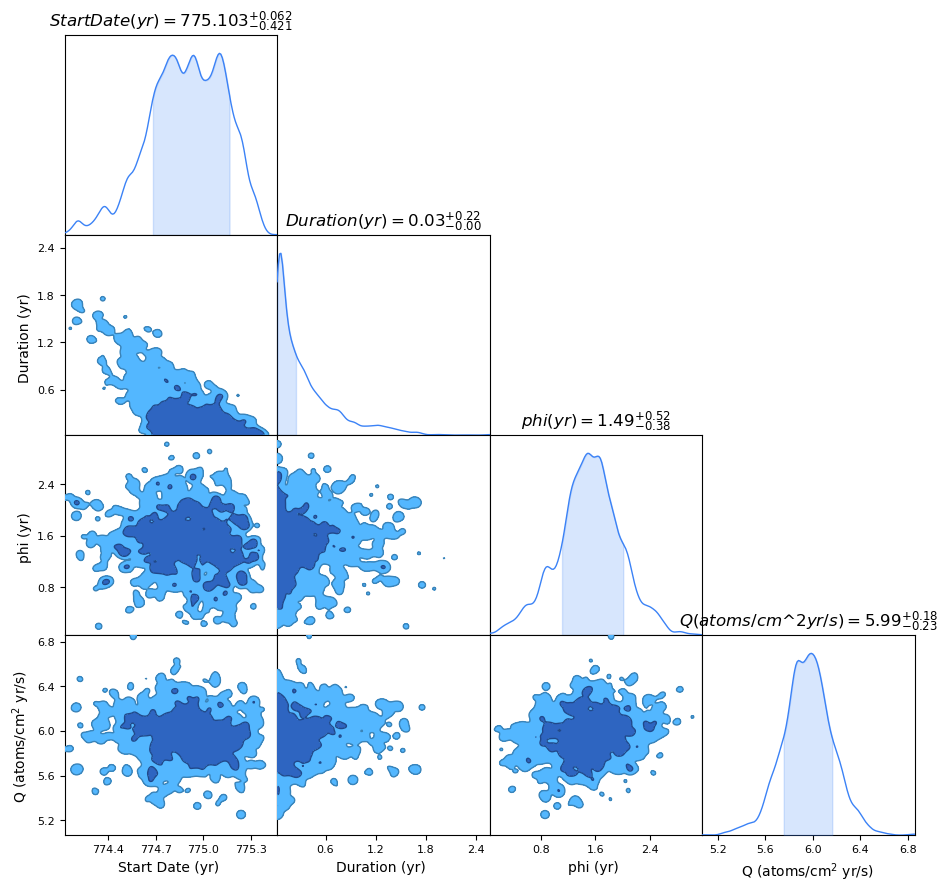

In [8]:
labels = ["Start Date (yr)", "Duration (yr)", "phi (yr)", "Q (atoms/cm$^2$ yr/s)"]
fig = sf.chain_summary(samples, 8, labels=labels,label_font_size=10)

And a plot of models evaluated from samples of the posterior parameters shows a pretty good fit!

100%|██████████| 30/30 [00:00<00:00, 249.34it/s]


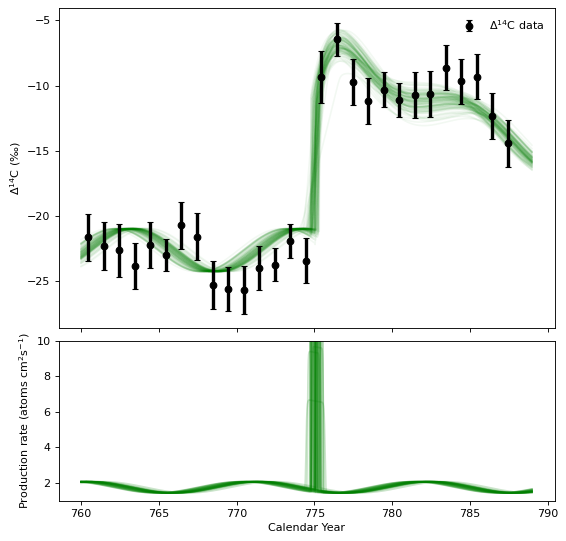

In [7]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(8, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]}, dpi=80)
fig.subplots_adjust(hspace=0.05)
plt.rcParams.update({"text.usetex": False})
idx = np.random.randint(len(sampler), size=100)
for param in tqdm(sampler[idx]):
    ax1.plot(sf.time_data_fine, sf.dc14_fine(params=param), alpha=0.05, color="g")

for param in tqdm(sampler[idx][:30]):
    ax2.plot(sf.time_data_fine, sf.production(sf.time_data_fine, *param), alpha=0.2, color="g")

ax1.errorbar(sf.time_data + sf.time_offset, sf.d14c_data, yerr=sf.d14c_data_error, 
             fmt="ok", capsize=3, markersize=6, elinewidth=3, label="$\Delta^{14}$C data")
ax1.legend(frameon=False);
ax2.set_ylim(1, 10);
ax1.set_ylabel("$\Delta^{14}$C (‰)")
ax2.set_xlabel("Calendar Year");
ax2.set_ylabel("Production rate (atoms cm$^2$s$^{-1}$)");